# EDA Project - Pynq Image Filters - Hardware Acceleration

This jupyter notebook implements the hardware acceleration fo the Pynq Image Filters project

## Pre Processing

Import necessary libraries and modules

In [1]:
from PIL import Image as PIL_Image
import numpy

import time

from pynq import Overlay
from pynq.mmio import MMIO

Set Constants used through out the code and set hardware address configuration

In [2]:
# Define verbosity
VERB = 0

# Padding boarder to proccess edge pixeis as any other pixel
PADSIZE = 8
if VERB != 0:
    print("Padsize:", PADSIZE)

# Real Block Size
BLK_HEIGHT = 128
BLK_WIDTH = 128
if VERB != 0:
    print("Block height:", BLK_HEIGHT)
    print("Block width:", BLK_WIDTH)

# Usable Block Size
BLK_UHEIGHT = BLK_HEIGHT - 2 * PADSIZE
BLK_UWIDTH = BLK_WIDTH - 2 * PADSIZE
if VERB != 0:
    print("Usable block height:", BLK_UHEIGHT)
    print("Usable block width:", BLK_UWIDTH)

# address configuration
# Input block has BLK_HEIGHTxBLK_WIDTH*4 bytes
ADDR_BASE_IN=0x40000000
ADDR_RANGE_IN=0x10000
# Input block has BLK_UHEIGHTxBLK_UWIDTH*4 bytes
ADDR_BASE_OUT=0x40020000
ADDR_RANGE_OUT=0xc400

Load the image and convert it to numpy arrays.

Loaded image:


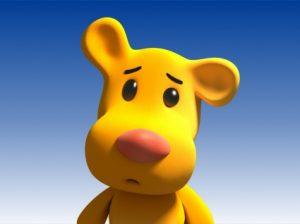

In [3]:
# load and display the image
imgOrig = PIL_Image.open("image0.jpg")
# get image height and width
imgWidth, imgHeight = imgOrig.size
origSize = (imgHeight, imgWidth)

if VERB != 0: 
    print("Input image original size:", origSize[0], origSize[1])

print("Loaded image:")
display(imgOrig)

# convert the image to a numpy array with dimensions (imgHeight x imgWidth x 3)
# each entry is an array with the three RGB intensity values, from 0 to 255
imgArr = numpy.asarray(imgOrig)

## Hardware Processing

Load the overlay

In [4]:
# load the overlay
overlay = Overlay('filters.bit')

Add padding to the image

In [5]:
padHeight = 0
padWidth = 0

# Verify necessity of padding on the height parameter
if imgHeight % BLK_UHEIGHT != 0:
    padHeight = max(0, BLK_UHEIGHT - imgHeight % BLK_UHEIGHT)

# Verify necessity of padding on the width parameter
if imgWidth % BLK_UWIDTH != 0:
    padWidth = max(0, BLK_UWIDTH - imgWidth % BLK_UWIDTH)

# Create padding tupple
padding = ((PADSIZE, padHeight + PADSIZE), (PADSIZE, padWidth+PADSIZE), (0,0))

# Create the image with padding
imgPadArr = numpy.pad(imgArr, padding, mode='edge')
# get image height and width
imgPadHeight, imgPadWidth, imgPadChannels = imgPadArr.shape

if VERB != 0:
    print("Padded image:")
    display(PIL_Image.fromarray(imgPadArr))
    print("Padding done:", padding)

Manipulate color RGB enconding and hardware processing of the padded image

In [6]:
print('Filtering image using hardware acceleration ...')

# start counting time
start_time = time.time()

# get MMIO handlers
inMMIO = MMIO(ADDR_BASE_IN, ADDR_RANGE_IN)
outMMIO = MMIO(ADDR_BASE_OUT, ADDR_RANGE_OUT)

# view linear memory areas as Bi Dimensonal matrices
# inMat are numpy.ndarray elements with dimensions BLK_HEIGHTxBLK_WIDTH
inMat = numpy.reshape(inMMIO.array,(BLK_HEIGHT,BLK_WIDTH))
# outMat are numpy.ndarray elements with dimensions BLK_UHEIGHTxBLK_UWIDTH
outMat = numpy.reshape(outMMIO.array,(BLK_UHEIGHT,BLK_UWIDTH))

# Create matrix to store the entire hardware output image (without padding)
imgArrAccel = numpy.full([origSize[0], origSize[1], 3], dtype=numpy.uint8, fill_value=0x00)
# Create matrix to store the entire hardware output image (padded)
imgArrAccelPad = numpy.full([imgPadHeight, imgPadWidth, 3], dtype=numpy.uint8, fill_value=0x00)

# Create matrix to store image RGB channels encoded in a single a byte (0x00RRBBGG)
imgPadArrShf = numpy.full([imgPadHeight, imgPadWidth], dtype=numpy.uint32, fill_value=0x00)

# Convert input array to uint32 so the vectorial intruction bellow (the encoding)
# does not maintain the original data type of the matrix imgPadArr
imgPadArr = imgPadArr.astype(numpy.uint32)
imgPadArrShf = (imgPadArr[:,:,0] << 16) | (imgPadArr[:,:,1] << 8) | imgPadArr[:,:,2]

# run BLK_HEIGHT x BLK_WIDTH slices of the image through the accelerator
for offsetRow in range(0, imgPadHeight - 2*PADSIZE, BLK_UHEIGHT):
    for offsetCol in range (0, imgPadWidth - 2*PADSIZE, BLK_UWIDTH):

        # write the BLK_HEIGHT x BLK_WIDTH slice to inMat
        startRow = offsetRow
        startCol = offsetCol
        endRow = offsetRow+BLK_HEIGHT
        endCol = offsetCol+BLK_WIDTH
        inMat[:,:] = imgPadArrShf[startRow:endRow,startCol:endCol]
        
        if VERB != 0:
            print("Starting:", offsetRow, offsetCol)
        
        # start the hardware kernel and wait for it to complete
        overlay.filter_Controller_0.register_map.CTRL.AP_START=1
        while overlay.filter_Controller_0.register_map.CTRL.AP_DONE == 0:
            pass
        
        if VERB != 0:
            print("Finished:", offsetRow, offsetCol)

        # read the BLK_UHEIGHT x BLK_UWIDTH slice from outMat
        startRow = offsetRow + PADSIZE
        startCol = offsetCol + PADSIZE
        endRow = offsetRow + BLK_UHEIGHT + PADSIZE
        endCol = offsetCol + BLK_UWIDTH + PADSIZE
        imgArrAccelPad[startRow:endRow,startCol:endCol,0] = 0xff & (outMat[:,:] >> 16)
        imgArrAccelPad[startRow:endRow,startCol:endCol,1] = 0xff & (outMat[:,:] >> 8)
        imgArrAccelPad[startRow:endRow,startCol:endCol,2] = 0xff & outMat[:,:]

# Remove padding
startRow = PADSIZE
startCol = PADSIZE
endRow = imgPadHeight - padHeight - PADSIZE
endCol = imgPadWidth - padWidth - PADSIZE
imgArrAccel[:,:,:] = imgArrAccelPad[startRow:endRow,startCol:endCol,:]

# end counting time and print execution time
end_time = time.time()
execution_time = end_time - start_time

print(f'Done. Run time: {execution_time}s.')

Filtering image using hardware acceleration ...
Done. Run time: 0.5781278610229492s.


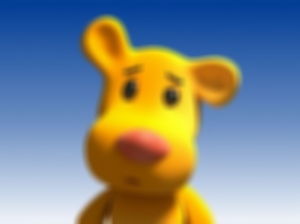

In [7]:
if VERB != 0:
    # Print output image with padding
    display(PIL_Image.fromarray(imgArrAccelPad))

# convert back to image
imgAccel = PIL_Image.fromarray(imgArrAccel)
display(imgAccel)